In [58]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [59]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [60]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

lemmatizer = WordNetLemmatizer()
print(tag_map)

def lemmatization(tweet):
  tokens = word_tokenize(tweet)
  tweet = ' '.join([lemmatizer.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens)])
  return tweet

defaultdict(<function <lambda> at 0x7f09559a51e0>, {'J': 'a', 'V': 'v', 'R': 'r'})


In [0]:
import re
import string
from bs4 import BeautifulSoup
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

#for tweet in tweet_data:
def preprocess_tweet(tweet):
    # Clean the training data
    # print(tweet)
    
    #Escaping HTML characters
    tweet = BeautifulSoup(tweet).get_text()
    
    #lowercase
    tweet = tweet.lower()
    
    #remove links
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))','',tweet)
    
    #Remove usernames
    tweet = re.sub('@[^\s]+','', tweet)
    
    # replace hashtags by just words
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    
    #Removal of Punctuation
    tweet = ' '.join(re.sub("[\.\,\!\?\:\;\-\=]", " ", tweet).split())
    
    #correct all multiple white spaces to a single white space
    tweet = re.sub('[\s]+', ' ', tweet)
   
    #remove space at the beginning and the end
    tweet = tweet.strip()

    #tweet = ''.join([lemmatizer.lemmatize(w) for w in tweet])
    tweet = lemmatization(tweet)
    
    # print(tweet)
    
    return tweet

In [62]:
import pandas as pd
import numpy as np
import re

usecols = (2,4)
train_dataframe = pd.read_table("/content/gdrive/My Drive/Colab Notebooks/task1_training.tsv",usecols=usecols)
test_dataframe = pd.read_table("/content/gdrive/My Drive/task1_validation.tsv",usecols=usecols)

print(train_dataframe.shape)
print(test_dataframe.shape)
print(train_dataframe.head())

(55419, 2)
(13853, 2)
                                               tweet  class
0  These new anti-anxiety meds make me so sleepy😴...      1
1  @xmermaidmama you can try vitamins for Olivia!...      1
2  Toby set up the humidifier for me in the room ...      1
3  I'm an 8. They also just started me on pitocin...      1
4  @sstuckeyy I didn't take prenatals at all, peo...      1


In [63]:
print(train_dataframe['class'].value_counts())
print(test_dataframe['class'].value_counts())

0    55273
1      146
Name: class, dtype: int64
0    13818
1       35
Name: class, dtype: int64


In [64]:
train_data = train_dataframe.iloc[:, 0]
train_label = train_dataframe.iloc[:, 1]
test_data = test_dataframe.iloc[:, 0]
test_label = test_dataframe.iloc[:, 1]
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)
print(train_data[0])
print(test_data[0])

(55419,)
(55419,)
(13853,)
(13853,)
These new anti-anxiety meds make me so sleepy😴💤 Not sure if It will work out for me.. But I'm so tired of always switching meds 😒
Cayden's already starting to open his eyes! The anesthesia might wear off sooner than we thought,… http://t.co/5sIVNKYfvi


In [65]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# print(train_data[0])
for index, tweet in enumerate(train_data):
  train_data[index] = preprocess_tweet(tweet)

for index, tweet in enumerate(test_data):
  test_data[index] = preprocess_tweet(tweet)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [66]:
print(train_data[0])
print(test_data[0])

these new anti anxiety med make me so sleepy😴💤 not sure if it will work out for me but i 'm so tired of always switch med 😒
cayden 's already start to open his eye the anesthesia might wear off sooner than we think …


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create feature vectors
vectorizer = TfidfVectorizer(#min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

In [68]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

counter = Counter(train_label)
print(counter)

# transform the dataset
# oversample = SMOTE(random_state=777)
# oversampled_train_data, oversampled_train_label = oversample.fit_resample(train_vectors, train_label)

# rus = RandomUnderSampler(random_state=777)
# oversampled_train_data, oversampled_train_label = rus.fit_sample(train_vectors, train_label)

over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.6) #0.3
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

oversampled_train_data, oversampled_train_label = pipeline.fit_resample(train_vectors, train_label)

# summarize the new class distribution
counter = Counter(oversampled_train_label)
print(counter)

Counter({0: 55273, 1: 146})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 36848, 1: 22109})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [69]:
import time
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
# Perform classification with SVM, kernel=linear
model = svm.SVC(kernel='linear')
t0 = time.time()
model.fit(oversampled_train_data, oversampled_train_label)
t1 = time.time()
prediction_linear = model.predict(test_vectors)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))


Training time: 56.568249s; Prediction time: 3.646920s


In [70]:
report = classification_report(test_label, prediction_linear, output_dict=True)
print('ADR: ', report['1'])
print('Non-ADR: ', report['0'])
target_names = ['NON ADR', 'ADR']
print(classification_report(test_label, prediction_linear, target_names=target_names))

ADR:  {'precision': 0.7916666666666666, 'recall': 0.5428571428571428, 'f1-score': 0.6440677966101694, 'support': 35}
Non-ADR:  {'precision': 0.9988430110637067, 'recall': 0.9996381531335938, 'f1-score': 0.9992404239157955, 'support': 13818}
              precision    recall  f1-score   support

     NON ADR       1.00      1.00      1.00     13818
         ADR       0.79      0.54      0.64        35

    accuracy                           1.00     13853
   macro avg       0.90      0.77      0.82     13853
weighted avg       1.00      1.00      1.00     13853



In [71]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

acc = accuracy_score(test_label, prediction_linear)
print(acc)

cf_matrix = confusion_matrix(test_label, prediction_linear)
print(cf_matrix)

0.9984840828701365
[[13813     5]
 [   16    19]]


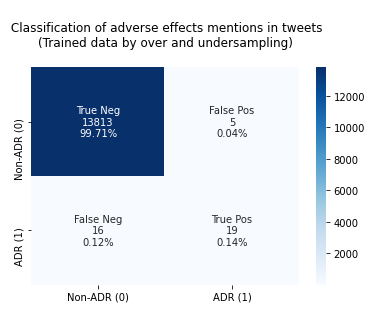

In [72]:
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
x_axis_labels = ['Non-ADR (0)', 'ADR (1)'] # labels for x-axis
y_axis_labels = ['Non-ADR (0)', 'ADR (1)'] # labels for y-axis
hm = sns.heatmap(cf_matrix, annot=labels, fmt='', xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap='Blues')
hm.set_title('\n Classification of adverse effects mentions in tweets\n(Trained data by over and undersampling)\n');

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

No Skill: ROC AUC=0.500
SVM: ROC AUC=0.771


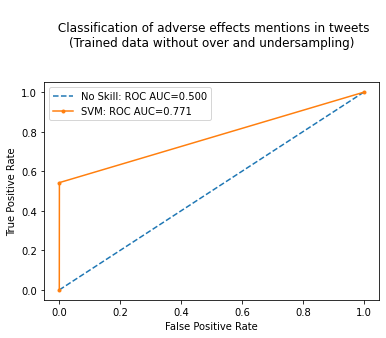

In [74]:
# calculate scores
ns_probs = [0 for _ in range(len(test_label))]
ns_auc = roc_auc_score(test_label, ns_probs)
svm_auc = roc_auc_score(test_label, prediction_linear)
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_label, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_label, prediction_linear)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('SVM: ROC AUC=%.3f' % (svm_auc))
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill: ROC AUC=%.3f'% (ns_auc))
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='SVM: ROC AUC=%.3f' % (svm_auc))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('\n Classification of adverse effects mentions in tweets\n(Trained data without over and undersampling)\n\n')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
# summarize scores


In [0]:
import pickle

#
# Create your model here (same as above)
#

# Save to file in the current working directory
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [0]:
prediction = pickle_model.predict(test_vectors)

In [77]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

acc = accuracy_score(test_label, prediction)
print(acc)

cf_matrix = confusion_matrix(test_label, prediction)
print(cf_matrix)

0.9984840828701365
[[13813     5]
 [   16    19]]
